## IMPORTANT

**Mustards, given that the ELA conversion runs for an hour or so I packaged the resulting NumPy arrays of X and Y in order to avoid that waiting whenever we are prototyping the CNN architecture. If you want to try the conversion yourselves, please feel free to go through the ELA.ipynb notebook in my branch.**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
# Basics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

# Image processing and ELA conversion
from PIL import Image
import os
from pylab import *
import re
from PIL import Image, ImageChops, ImageEnhance

# General ML models
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools
# from pandas_ml import ConfusionMatrix


# CNN
import tensorflow as tf
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras import regularizers

sns.set(style='white', context='paper', palette='deep')
np.random.seed(2)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [0]:
def get_imlist(path):
    '''
    path: path to the folder containing all the images to work with
    '''
    return [os.path.join(path,f) for f in os.listdir(path) if f.endswith('.jpg') or f.endswith('.png')]


def convert_to_ela_image(path, quality):
    '''
    path: path to the folder containign all the images to convert
    quality: number between 0 and 100 (Recommended 90) to denote the quality in whihc the .jpg image will be resaved
    '''
    filename = path
    resaved_filename = filename.split('.')[0] + '.resaved.jpg'
    ELA_filename = filename.split('.')[0] + '.ela.png'
    
    im = Image.open(filename).convert('RGB')
    im.save(resaved_filename, 'JPEG', quality=quality)
    resaved_im = Image.open(resaved_filename)
    
    ela_im = ImageChops.difference(im, resaved_im)
    
    extrema = ela_im.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1
    scale = 255.0 / max_diff
    
    ela_im = ImageEnhance.Brightness(ela_im).enhance(scale)
    
    return ela_im

In [0]:
paths = get_imlist('/Users/luxiao/Desktop/Final_Project/dataset')

# Create dataframe with file names
dataset = pd.DataFrame(paths, columns = ['file_name'])

# assign class according to file name
dataset['fake'] = 0

dataset['fake'] = np.where(dataset['file_name'].str.endswith('_fake.jpg'), 1, dataset['fake'])

# check the balance of the dataset
pd.crosstab(index = dataset['fake'], columns = 'Freq')/len(paths)*100

col_0,Freq
fake,
0,50.0
1,50.0


### Code to convert to ELA all the images

The code below will do the trick to convert all our dataset into ELA images and reduce their size to 128x128 pixels. 50 images yielded errors when converting them to ELA and where dropped from the analysis. *dataset_correct* is created to update the index with the above issue in mind.

```python 

X = []
Y = []

new_index = []
for index, row in dataset.iterrows():
    try:
        X.append(array(convert_to_ela_image(row[0], 90).resize((128, 128))).flatten() / 255.0)
        Y.append(row[1])
        new_index.append(index)
    except:
        print("Image {} dropped. Could not be processed.".format(re.sub('D:/ML final project/PS_Battles/dataset/', '', dataset['file_name'][index])))
        pass

    if index % 1000 == 0:

        print(index, "images parsed")

dataset_correct = dataset[dataset.index.isin(new_index)]
dataset_correct = dataset_correct.reset_index(drop=True)


X = np.array(X)
X = X.reshape(-1, 128, 128, 3)

Y = tf.keras.utils.to_categorical(Y, 2)  
```

### Important: Run this cell to upload the objects needed

To download the objects go to the project repo, next go to my branch and then go into the *10_code* folder. There you will find a file called *numpy_files.txt* with the links to download these objects

Please change the paths accordingly.

In [0]:
dataset_correct = pd.read_csv("/Users/luxiao/Desktop/Final_Project/dataset_correct.csv")

In [0]:
X = np.load("/content/drive/My Drive/fake-or-not/data/ps_battles_ela_X.npy")
Y = np.load("/content/drive/My Drive/fake-or-not/data/ps_battles_ela_Y.npy")

In [0]:
X = 1

In [0]:
X.shape

(21182, 128, 128, 3)

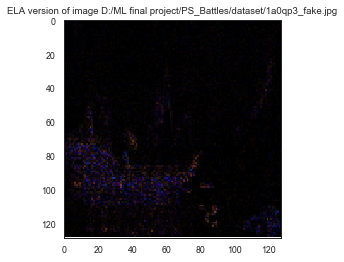

FileNotFoundError: [Errno 2] No such file or directory: '/Users/luxiao/Desktop/Final_Project/dataset/D:/ML final project/PS_Battles/dataset/1a0qp3_fake.jpg'

In [0]:
# Take a look at a sample image

def plot_image(img_num):
    
    file_name = dataset_correct['file_name'][img_num]
    img_name = re.sub('/Users/luxiao/Desktop/Final_Project/dataset/', '', file_name)
    
    plt.imshow(X[img_num], interpolation='nearest')
    plt.title("ELA version of image {}".format(img_name))
    plt.show()
    return img_name

# Cheerleaders fake image 

# Fake
im_name = plot_image(2220)   

# Original
Image.open('/Users/luxiao/Desktop/Final_Project/dataset/'+im_name) 

In [0]:
# Split into training and validation

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 0.2, random_state=3)

In [0]:
X_train.shape

(16945, 128, 128, 3)

In [0]:
X_train_cut = X_train[1:8000]

In [0]:
Y_train_cut = Y_train[1:8000]

## First CNN architecture building:

In [6]:
# Release GPU memory

tf.keras.backend.clear_session()


try:
    del model
except:
    print("No model in memory")

No model in memory


In [7]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters = 64, kernel_size = (5,5),padding = 'valid', 
                     activation ='relu', input_shape = (128,128,3)),

    tf.keras.layers.Conv2D(filters = 32, kernel_size = (5,5),padding = 'valid', 
                     activation ='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.Conv2D(filters = 32, kernel_size = (5,5),padding = 'valid', 
                     activation ='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation = "relu",kernel_regularizer=regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(2, activation = "sigmoid",kernel_regularizer=regularizers.l2(0.01))
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 124, 124, 64)      4864      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 120, 120, 32)      51232     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 60, 60, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 32)        25632     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 28, 28, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 28, 28, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0

In [0]:
# Model tools

optimizer = tf.keras.optimizers.RMSprop(lr=0.0005, rho=0.9, epsilon=1e-08, decay=0.0)

model.compile(optimizer = optimizer , loss = "binary_crossentropy", metrics=["accuracy"])

# I test two stopping criterias:

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                              min_delta=0,
                              patience=2,
                              verbose=0, mode='auto')

class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.999):
      print("\nReached 99.9% accuracy so cancelling training!")
      self.model.stop_training = True

callbacks = myCallback()

In [10]:
# Training

epochs = 50
batch_size = 100


history = model.fit(X_train, Y_train, batch_size = batch_size, epochs = epochs,
          validation_data = (X_val, Y_val), callbacks=[callbacks])

Epoch 1/50
170/170 [==============================] - 13s 78ms/step - loss: 0.8377 - accuracy: 0.6446 - val_loss: 0.6419 - val_accuracy: 0.6870
Epoch 2/50
170/170 [==============================] - 13s 75ms/step - loss: 0.6466 - accuracy: 0.6764 - val_loss: 0.6399 - val_accuracy: 0.6755
Epoch 3/50
170/170 [==============================] - 13s 75ms/step - loss: 0.6377 - accuracy: 0.6846 - val_loss: 0.6119 - val_accuracy: 0.7066
Epoch 4/50
170/170 [==============================] - 13s 75ms/step - loss: 0.6302 - accuracy: 0.6888 - val_loss: 0.6091 - val_accuracy: 0.7043
Epoch 5/50
170/170 [==============================] - 13s 75ms/step - loss: 0.6287 - accuracy: 0.6887 - val_loss: 0.6169 - val_accuracy: 0.6955
Epoch 6/50
170/170 [==============================] - 13s 75ms/step - loss: 0.6263 - accuracy: 0.6914 - val_loss: 0.6125 - val_accuracy: 0.7071
Epoch 7/50
170/170 [==============================] - 13s 75ms/step - loss: 0.6225 - accuracy: 0.6934 - val_loss: 0.6106 - val_accuracy:

In [0]:
# Training

epochs = 20
batch_size = 100


history = model.fit(X_train_cut, Y_train_cut, batch_size = batch_size, epochs = epochs,
          validation_data = (X_val, Y_val), callbacks=[callbacks])

Train on 7999 samples, validate on 4237 samples
Epoch 1/20
7999/7999 [==============================] - 896s 112ms/sample - loss: 0.6499 - accuracy: 0.6817 - val_loss: 0.6436 - val_accuracy: 0.6782
Epoch 2/20
4600/7999 [================>.............] - ETA: 6:09 - loss: 0.6491 - accuracy: 0.6761

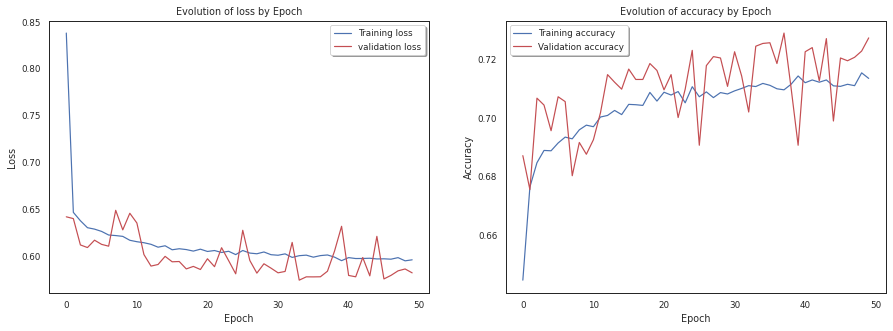

In [11]:
# Plot the loss and accuracy curves for training and validation

fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
ax[0].set_ylabel("Loss")
ax[0].set_xlabel("Epoch")
ax[0].set_title("Evolution of loss by Epoch")
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax[1].set_ylabel("Accuracy")
ax[1].set_xlabel("Epoch")
ax[1].set_title("Evolution of accuracy by Epoch")
legend = ax[1].legend(loc='best', shadow=True)

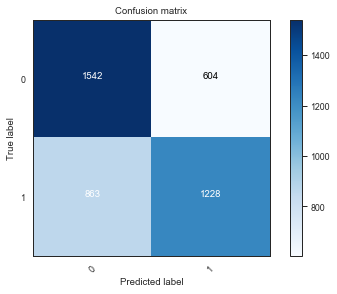

In [0]:
# Confusion matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors
Y_pred_classes = np.argmax(Y_pred,axis = 1)
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1)
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(2))

# ~65% accuracy